<a href="https://colab.research.google.com/github/x86-512/2025-Quantum-Factorization-With-Quantum-Rings/blob/main/TeamLOTRSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit==1.3.1
!pip install QuantumRingsLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.3 MB/s eta 0:00:00


                  ┌───┐ ╎                                              »
Q[0]:            ■┤ H ├─╎───■────■────■────■────■────■────■────■────■──»
                  ├───┤ ╎   │    │    │    │    │    │    │    │    │  »
Q[1]:            ■┤ H ├─╎───│────│────│────│────│────│────│────│────│──»
                  ├───┤ ╎   │    │    │    │    │    │    │    │    │  »
Q[2]:            ■┤ H ├─╎───│────│────│────│────│────│────│────│────│──»
                  ├───┤ ╎   │    │    │    │    │    │    │    │    │  »
Q[3]:            ■┤ H ├─╎───│────│────│────│────│────│────│────│────│──»
                  ├───┤ ╎   │    │    │    │    │    │    │    │    │  »
Q[4]:            ■┤ H ├─╎───│────│────│────│────│────│────│────│────│──»
                  ├───┤ ╎   │    │    │    │    │    │    │    │    │  »
Q[5]:            ■┤ H ├─╎───│────│────│────│────│────│────│────│────│──»
                  ├───┤ ╎   │    │    │    │    │    │    │    │    │  »
Q[6]:            ■┤ H ├─╎───│────│────│────│────│──

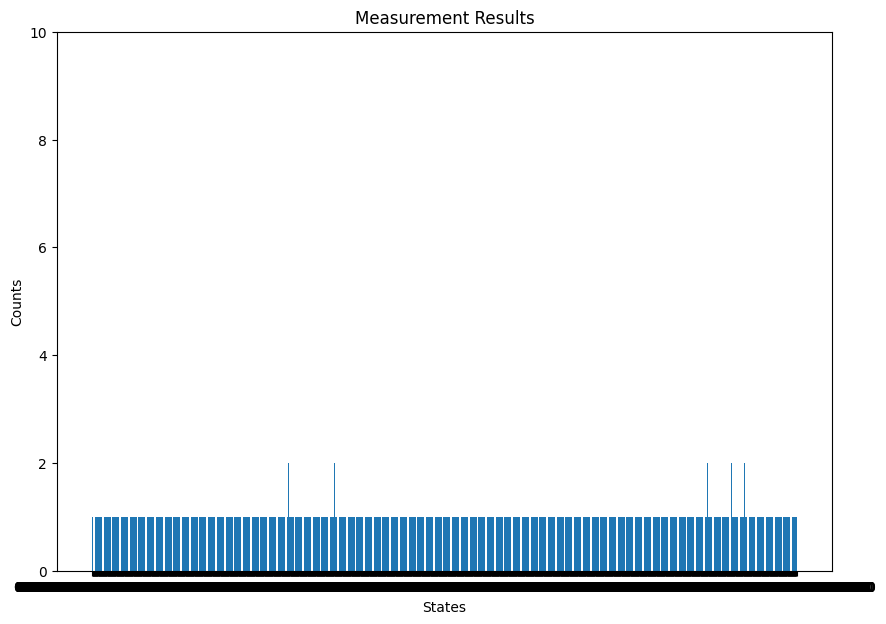

NameError: name 'qc' is not defined

In [1]:
from QuantumRingsLib import QuantumRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from fractions import Fraction

def find_base(N):
  while True:
    a = random.randint(2, N - 1)
    if math.gcd(a, N) == 1:
      return a

def find_period(measured_value, num_bits):
    decimal_s = int(measured_value, 2)  # Convert binary to decimal
    fraction = Fraction(decimal_s, 2**num_bits).limit_denominator()
    return fraction.denominator  # The denominator is r

def find_factors(N, a, r):
    if r % 2 != 0:  # Period must be even
        return None

    factor1 = math.gcd(pow(a, r // 2, N) - 1, N)
    factor2 = N // factor1

    if factor1 * factor2 == N and factor1 != 1 and factor2 != 1:
        return factor1, factor2
    return None

# Initialize QuantumRings provider
provider = QuantumRingsProvider(
    token='[REDACTED]',  # Replace with your token
    name='[REDACTED]'    # Replace with your email
)
backend = provider.get_backend("scarlet_quantum_rings")
provider.active_account()

# Function to implement the inverse Quantum Fourier Transform (IQFT)
def iqft_cct(qc, b, n):
    for i in range(n):
        for j in range(1, i + 1):
            qc.cu1(-math.pi / 2 ** (i - j + 1), b[j - 1], b[i])
        qc.h(b[i])
    qc.barrier()

# Function to perform modular exponentiation
def modular_exponentiation(qc, a, N, control_qubits, target_qubits):
    n = len(control_qubits)
    for i in range(n):
        power = 2 ** i
        a_power = pow(a, power, N)
        for j in range(len(target_qubits)):
            if (a_power >> j) & 1:
                qc.cx(control_qubits[i], target_qubits[j])

# Function to plot histogram of measurement results
def plot_histogram(counts, title=""):
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]
    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)
    plt.bar(unique, bin_counts)
    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    plt.title(title)
    plt.show()

# Main function
def main():
    # Using a 30-bit semiprime (can be changed to 40-bit for higher difficulty)
    N = 167659  # A 30-bit semiprime
    num_bits = int(math.ceil(math.log2(N)))
    numberofqubits = num_bits * 2 - 1
    period_bit_size = numberofqubits - num_bits
    shots = 2048  # Increased shots for better accuracy

    # Create quantum and classical registers
    q_merged = QuantumRegister(numberofqubits, 'Q_Registers')
    classical = ClassicalRegister(num_bits, 'c')
    qc = QuantumCircuit(q_merged, classical)

    # Initialize superposition
    for i in range(period_bit_size):
        qc.h(q_merged[i])
    qc.x(q_merged[numberofqubits - 1])
    qc.barrier()

    # Modular exponentiation
    a = find_base(N) # Base for modular exponentiation
    control_qubits = [q_merged[i] for i in range(period_bit_size)]
    target_qubits = [q_merged[i] for i in range(period_bit_size, numberofqubits)]
    modular_exponentiation(qc, a, N, control_qubits, target_qubits)
    qc.barrier()

    # Apply inverse QFT
    iqft_cct(qc, control_qubits, period_bit_size)

    # Measure the qubits
    for i in range(period_bit_size):
        qc.measure(q_merged[i], classical[i])

    # Draw the circuit
    qc.draw('mpl')

    # Run the circuit on the QuantumRings backend
    job = backend.run(qc, shots=shots)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts()

    # Remove the '0000' state if present
    if '0000' in counts:
        del counts['0000']


    # Plot the histogram of measurement results
    plot_histogram(counts, title="Measurement Results")

    # After measuring the value
    measured_value = max(counts, key=counts.get)
    print(f"Most frequent measurement: {measured_value}")

    # Convert binary to decimal
    decimal_value = int(measured_value, 2)

    # Compute the fraction
    n = len(measured_value)
    fraction = Fraction(decimal_value, 2**n).limit_denominator()

    # Extract the denominator (period r)
    r = fraction.denominator
    print(f"Computed period: r = {r}")

    # Validate the period
    if pow(a, r, N) == 1:
        print("Period is valid.")
        factors = find_factors(N, a, r)
        if factors:
            p, q = factors
            print(f"Found factors: p = {p}, q = {q}")
        else:
            print("Failed to find valid factors. Try another base.")
    else:
        print("Invalid period. Try another base.")
    # Factor extraction logic needed here

if __name__ == "__main__":
    main()